In [1]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwpy.frequencyseries import FrequencySeries
from gwpy.signal import filter_design
from gwpy.plot import Plot

import numpy as np
import matplotlib.pyplot as plt
import plotfancy as pf
pf.housestyle_rcparams()

def fix_frame(ax):
    ax.tick_params(color='black', labelcolor='black')
    ax.spines[:].set_color('black')
    ax.spines[:].set_linewidth(1)
    return True

def fix_plot(a):
    for axes in a:
        axes.grid(False)
        pf.do_ticks([axes])
        fix_frame(axes)
    return True
    

## Part 1: *Time Series Tools*
**First** let's import some data to test the pointing methods for gwosc, and plot using the built-in plotting methods from gwpy.

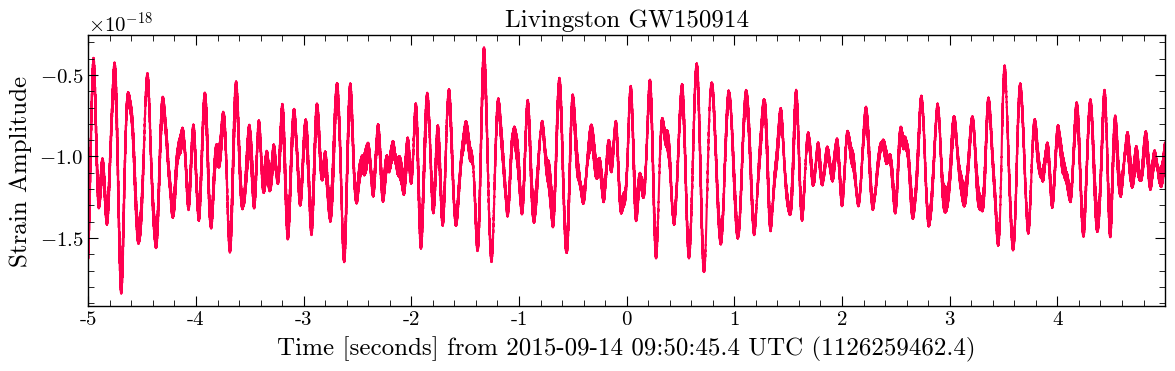

In [2]:
gps = event_gps('GW150914')
data = TimeSeries.fetch_open_data('L1', gps-5, gps+5)
plot = data.plot(
    title = 'Livingston GW150914',
    ylabel = 'Strain Amplitude',
    color = '#ff004f',
    epoch = gps
)
ax = plot.gca()
fix_plot([ax])

plt.tight_layout()
plt.savefig(f'out/TS_raw.png',bbox_inches='tight', dpi=900)

This signal is dominated by low-frequency noise, so let's apply some signal filtering techniques to extract the grav wave signal.

<>:29: SyntaxWarning: invalid escape sequence '\,'
<>:29: SyntaxWarning: invalid escape sequence '\,'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_13763/3525935840.py:29: SyntaxWarning: invalid escape sequence '\,'
  ax2.text(1,1.01, f'50-250\,Hz Bandpass. Notches at 60, 120, 180', transform = ax2.transAxes, ha='right')


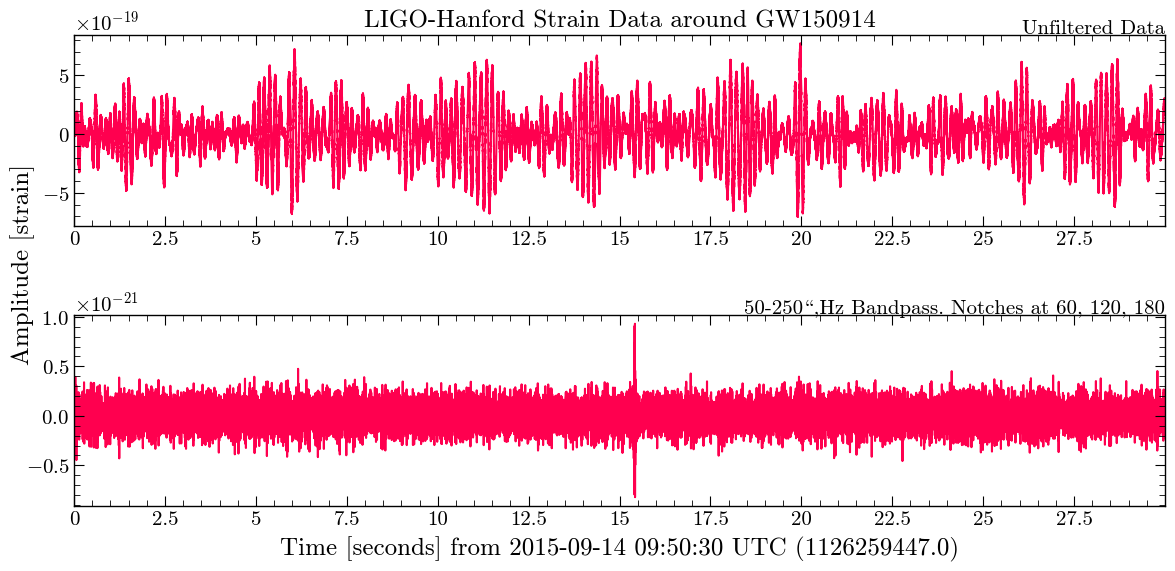

In [3]:
hdata = TimeSeries.fetch_open_data('H1', 1126259446,1126259478)

### - designing a zero-pole-gain filter to remove noise - ###

bp = filter_design.bandpass(50,250, hdata.sample_rate) # 50-250hz bandpass
notches = [filter_design.notch(line, hdata.sample_rate) for line in (60,120,280)] # removing AC mains harmonics
zpk = filter_design.concatenate_zpks(bp, *notches)

### - apply the filter to the data, going backwards and forwards - ###

hfilt = hdata.filter(zpk, filtfilt = True) # however this creates corruptions at the start and end so we discard bits

# for x in [hdata,hfilt]:
#     x = x.crop(*x.span.contract(1))

hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

### - doing some plotting - ###

plot = Plot(hdata, hfilt, figsize = (12,6), separate = True, sharex=True, color='#ff004f')
ax1, ax2 = plot.axes

ax1.set_title('LIGO-Hanford Strain Data around GW150914')
ax1.text(1,1.01, 'Unfiltered Data', transform = ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)

ax2.set_ylabel('')
ax2.text(1,1.01, f'50-250\,Hz Bandpass. Notches at 60, 120, 180', transform = ax2.transAxes, ha='right')

fix_plot([ax1,ax2])

plt.tight_layout()
plt.savefig(f'out/TS_filter.png',bbox_inches='tight', dpi=900)

*Zooming into the spike around the gravitational wave*

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gwpy/plot/plot.py:297: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


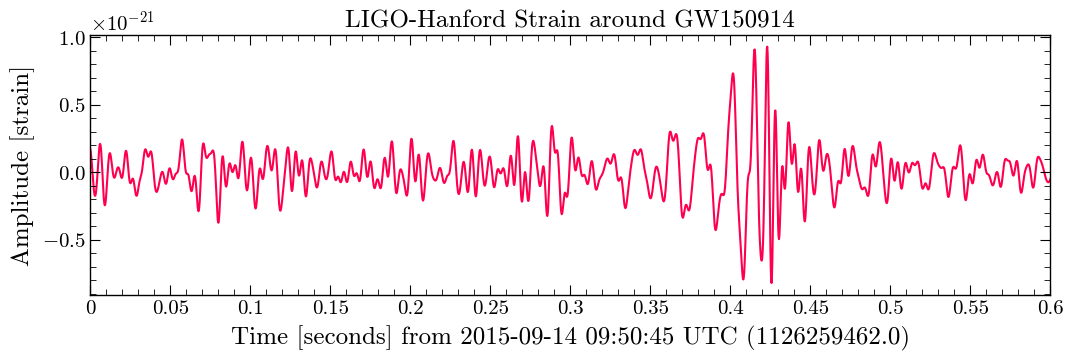

In [4]:
plot = hfilt.plot(color='#ff004f')
ax = plot.gca()

ax.set_title('LIGO-Hanford Strain around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()
fix_plot([ax])
plt.savefig(f'out/TS_filter_zoom.png',bbox_inches='tight', dpi=900)

**Now** we'll plot the filtered data alongside filtered data from LIGO-Livingston.

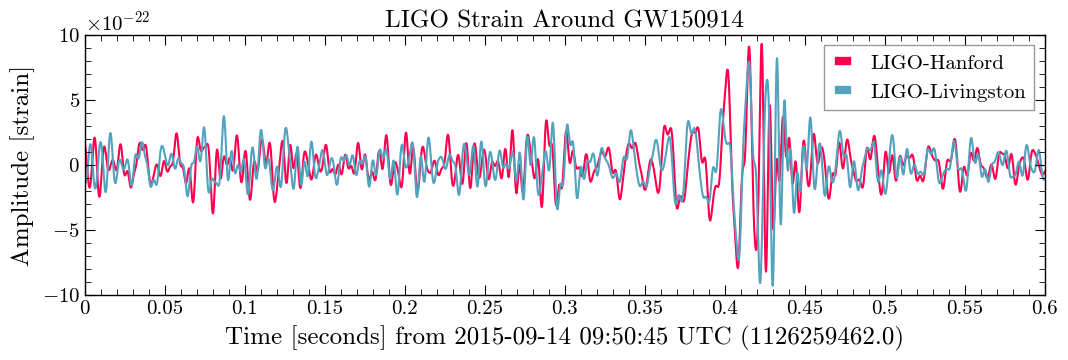

In [5]:
### - fetching the data from livingston - ###

ldata = TimeSeries.fetch_open_data('H1', 1126259446,1126259478)

### -  filtering it using our filter before - ###

lfilt = ldata.filter(zpk, filtfilt = True)

### - we know from the paper that the detectors are separated by 6.9ms and need flipping - ###

lfilt.shift('6.9ms')
lfilt *= -1

### - finally plotting - ###

plot = Plot(figsize=(12,4))
ax = plot.gca()

ax.plot(hfilt, label='LIGO-Hanford', color ='#ff004f')
ax.plot(lfilt, label='LIGO-Livingston', color ='#53A2BE')

ax.set_title('LIGO Strain Around GW150914')
ax.set_xlim(1126259462,1126259462.6)
ax.set_ylim(-1e-21,1e-21)
ax.set_xscale('seconds', epoch = 1126259462)
ax.set_ylabel('Amplitude [strain]')
ax.legend()
fix_plot([ax])
plt.savefig(f'out/TS_filter_zoom_HL.png',bbox_inches='tight', dpi=900)

## Part 2: *Frequency Series Tools*

Let's start by having a look at the frequency spectrum of the data above before the filtiering. Note the sharp spikes around the AC harmonics, and the sub-100Hz roll-on from seismic noise.

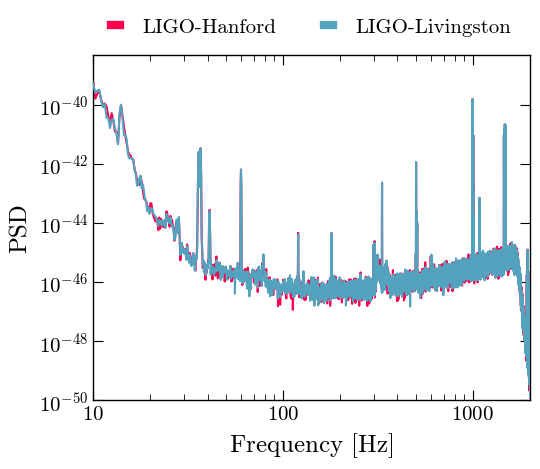

In [6]:
### - calculating the PSD for each bin in the data - argument asd(fftlength=4, overlap=2) - ###

lhoasd = ldata.psd(4,2) 
lloasd = hdata.psd(4,2)

### - plotting - ###

plot = lhoasd.plot(label='LIGO-Hanford', color='#ff004f', alpha=1)
ax = plot.gca()

ax.plot(lloasd, label='LIGO-Livingston', color='#53A2BE', alpha=1, zorder=10)
ax.set_xlim(10,2000)
ax.set_ylim(1e-50, 5e-39)
ax.set_ylabel(r'PSD')

ax.legend(frameon=False, bbox_to_anchor = (1,1), loc='lower right', ncol=2)
fix_plot([ax])
plt.savefig(f'out/FS_PSD.png',bbox_inches='tight', dpi=900)

What about the same thing but looking at the filtered data instead?

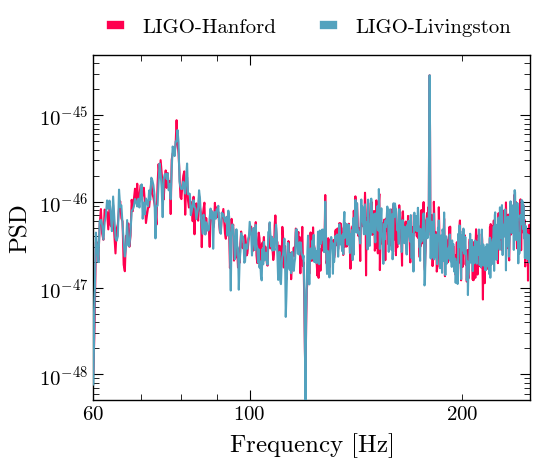

In [7]:
### - calculating the ASD for each bin in the data - argument asd(fftlength=4, overlap=2) - ###

lhoasd = hfilt.psd(4,2) 
lloasd = lfilt.psd(4,2)

### - plotting - ###

plot = lhoasd.plot(label='LIGO-Hanford', color='#ff004f', alpha=1)
ax = plot.gca()

ax.plot(lloasd, label='LIGO-Livingston', color='#53A2BE', alpha=1, zorder=10)
ax.set_xlim(60,250)
ax.set_ylim(5e-49, 5e-45)
ax.set_ylabel(r'PSD')

ax.legend(frameon=False, bbox_to_anchor = (1,1), loc='lower right', ncol=2)
fix_plot([ax])
plt.savefig(f'out/FS_PSD_filtered.png',bbox_inches='tight', dpi=900)

Now, Let's look at the spread of a noise distribution for a different event:

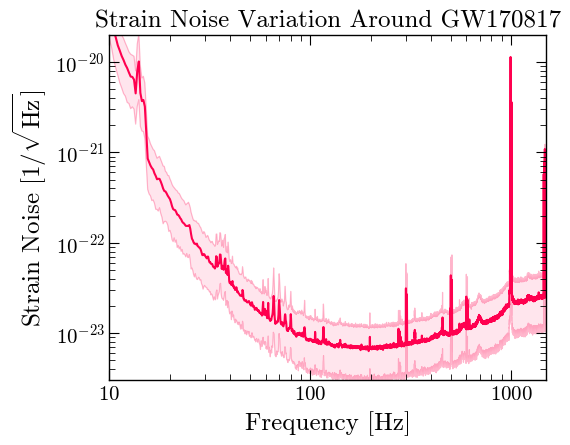

In [8]:
hoft = TimeSeries.fetch_open_data('H1', 1187007040, 1187009088)

for data in [hoft]: # keeping this as a for loop in case I want to do this to other bits of data
    
    sg = data.spectrogram2(fftlength=4, overlap=2, window='hann')**(1/2) # using an ASD spectrogram here
    
    median = sg.percentile(50)
    low = sg.percentile(5)
    high = sg.percentile(95)

    plot = Plot()
    ax = plot.add_subplot(
        xscale = 'log', xlim = (10,1500), xlabel='Frequency [Hz]',
        yscale = 'log', ylim = (3e-24,2e-20),
        ylabel = r'Strain Noise [1/$\sqrt{\mathrm{Hz}}]$'
    )

    ax.plot_mmm(median, low, high, color='#ff004f')
    ax.set_title('Strain Noise Variation Around GW170817')

    fix_plot([ax])
plt.savefig(f'out/FS_var.png',bbox_inches='tight', dpi=900)

What about the coherence between different sets of timeseries data?

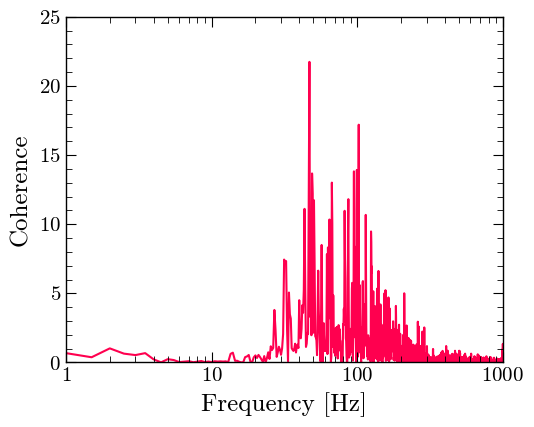

In [9]:
### - Retrieving the motion of the beam periscope to the main laser table - ###

# data = TimeSeriesDict.get(
#     ['H1:GDS-CALIB_STRAIN', 'H1:PEM-CS_ACC_PSL_PERISCOPE_X_DQ'],
#     112620017,
#     112620617,)

# hoft = data['H1:GDS-CALIB_STRAIN'] # Strain Output
# acc = data['H1:PEM-CS_ACC_PSL_PERISCOPE_X_DQ'] # PSL Periscope Accelerometer

### - NOTE THE ABOVE NOT WORKING BECAUSE OF NDS2??? - USING PREVIOUS DATA INSTEAD --- ###

### - Now calculate the coherence using a 2-second F-Transform - ###

coh = hdata.coherence(ldata, fftlength=2, overlap=1)

### - and plotting - ###

plot = coh.plot(
    xlabel = 'Frequency [Hz]', xscale ='log', xlim = (1,1000),
    ylabel='Coherence', yscale='linear', ylim=(0,25),
    color = '#ff004f'
)
ax = plot.gca()
fix_plot([ax])

plt.savefig(f'out/FS_coh.png',bbox_inches='tight', dpi=900)

Finally, let's try **injecting a signal**

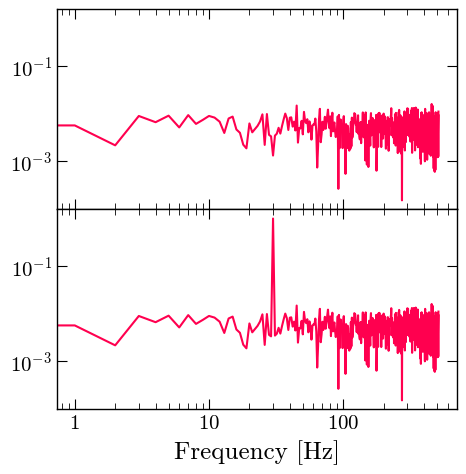

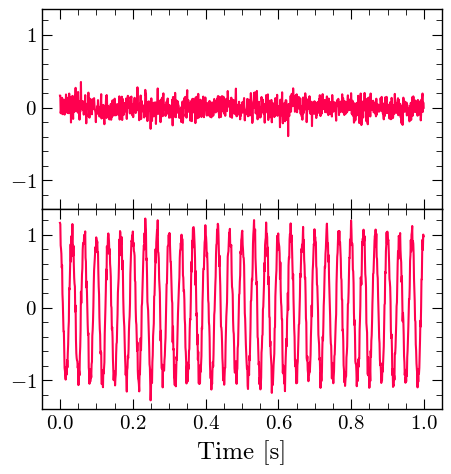

In [10]:
### - Starting by generating some random noise in the TD - ###

noise = TimeSeries(np.random.normal(scale=0.1, size=1024), sample_rate=1024)
noisefd = noise.fft() # Transform to Frequency Space

timespace = np.linspace(0,1,1024)

### - Now create a 30hz signal to inject - ###

signal = FrequencySeries(np.array([1]), f0=30, df=noisefd.df)

### - using the inject() function we pipe to the noise signal - ###

injfd = noisefd.inject(signal)

### - doing some plotting - ###
fbase = [np.abs(noisefd), np.abs(injfd)]
tbase = [noise, injfd.ifft()]
label = ['Frequency [Hz]', 'Time [s]']

for i,data in enumerate([fbase,tbase]):
    fig,ax1 = pf.create_plot(size=(4,2))
    if i == 0:
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    ax2 = fig.add_axes((0,-1,1,1), sharex=ax1, sharey=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)


    ax1.plot(data[0], color='#ff004f')
    ax2.plot(data[1], color='#ff004f')

    
    ax2.set_xlabel(label[i])
    
    fix_plot([ax1,ax2])



plt.savefig(f'out/FS_inj.png',bbox_inches='tight', dpi=900)